In [1]:
import os
import glob
import random
import cv2 as cv
import numpy as np
import timm
import torch
import torch.nn as nn
import torchvision
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from sklearn.cluster import AgglomerativeClustering, BisectingKMeans, DBSCAN, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import fowlkes_mallows_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import v2

# Feature Extraction

In [2]:
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

In [3]:
def get_image(annot):
    img_path = "../images/"
    file = annot.split('\\')
    img_filename = img_path + file[-2] + "/" + file[-1] + ".jpg"
    return img_filename

In [4]:
def image_resizing(dog_images, annotations):
    for i in range(len(dog_images)):
        bbox = get_bounding_boxes(annotations[i])
        dog = get_image(annotations[i])
        image = Image.open(dog)
        for j in range(len(bbox)):
            image_2 = image.crop(bbox[j])
            image_2 = image_2.resize((224,224), Image.Resampling.LANCZOS)
            new_path = dog.replace('../images/','../Resized/')
            new_path = new_path.replace('.jpg','-' + str(j) + '.jpg')
            image_2 = image_2.convert('RGB')
            head, tail = os.path.split(new_path)
            Path(head).mkdir(parents=True, exist_ok=True)
            image_2.save(new_path)

In [5]:
dog_images = glob.glob("../images/*/*")
annotations = glob.glob("../annotations/*/*")
image_resizing(dog_images, annotations)

In [6]:
def get_images():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    
    no_of_images = []
    for folder in folders:
        files = [f for f in os.listdir(f"../Resized/{folder}") if os.path.isfile(os.path.join(f"../Resized/{folder}", f))]
        no_of_images.append(len(files))
        
    collection = {}
    for folder, count in zip(folders, no_of_images):
        all_files = os.listdir(f"../Resized/{folder}")
        collection[folder] = all_files     
    
    return collection, folders

In [7]:
collection, folders = get_images()

In [8]:
def get_pixels():
    pixels = {}
    for folder, images in collection.items():
        combine = []
        for img in images:
            path = f"../Resized/{folder}/{img}"
            loaded_image = cv.imread(path)
            combine.append(loaded_image)
        combine = np.array(combine)
        pixels[folder] = combine
    
    return pixels

In [9]:
pixels = get_pixels() 

In [10]:
class_1_images = pixels[folders[0]]
class_2_images = pixels[folders[1]]
class_3_images = pixels[folders[2]]
class_4_images = pixels[folders[3]]

class_1_label = np.full(len(class_1_images), 0)  
class_2_label = np.full(len(class_2_images), 1)  
class_3_label = np.full(len(class_3_images), 2)  
class_4_label = np.full(len(class_4_images), 3)  

In [11]:
class_labels = np.concatenate((class_1_label, class_2_label, class_3_label, class_4_label), axis = 0)
class_data = np.concatenate((class_1_images, class_2_images, class_3_images, class_4_images), axis=0)

In [12]:
def normalized_dataset():   
    class_images = class_data / 255.0
    return class_images

In [13]:
class_data = normalized_dataset()

In [14]:
device = torch.device("cpu")
model = models.resnet18(pretrained=True)
model = nn.Sequential(*(list(model.children())[:-1]))
model.eval()

C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [15]:
def get_features(name):
    def hook(model, input, output):
        FEATS[name] = output.detach()
    return hook

In [16]:
model.register_forward_hook(get_features('feats'))

In [17]:
transform = v2.Compose([
    v2.ToImage(),     
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

i_classes = []
for image in class_data:
    transformed_images = transform(image)
    i_classes.append(transformed_images)

In [18]:
image_classes = DataLoader(i_classes, batch_size = 31, shuffle = False)

In [19]:
features = []
FEATS = {}

for i, image in enumerate(image_classes):
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image.float())
        features.append(FEATS['feats'].cpu().numpy())

In [20]:
features = np.array(features)

print("features shape:", features.shape)

features shape: (21, 31, 512, 1, 1)


In [21]:
features = features.reshape((651, -1))
features.shape

(651, 512)

In [22]:
def dimensionality_reduction():    
    pca = PCA(n_components = 2) 
    transformed_data = pca.fit_transform(features)
    
    for i in range(4):
        c = np.flatnonzero(class_labels == i)
        plt.scatter(transformed_data[c, 0], transformed_data[c, 1])
    plt.show()
    
    return transformed_data

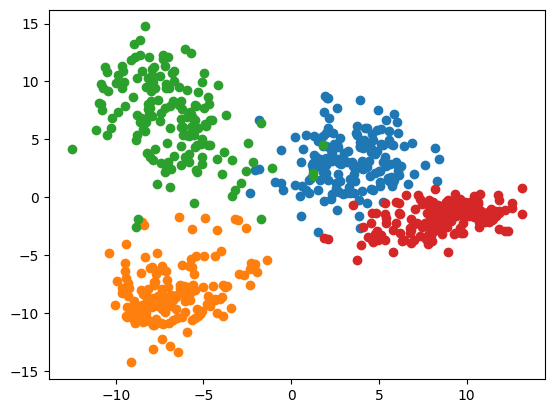

In [23]:
X = dimensionality_reduction()

# Clustering Algorithms

In [24]:
def k_means_clustering(X):
    kmeans = KMeans(n_clusters=4, random_state=0, init="random", n_init="auto").fit(X)
    
    return kmeans

In [25]:
def k_means_plus(X):
    kmeans_plus = KMeans(n_clusters=4, random_state=0, init="k-means++", n_init="auto").fit(X)
    
    return kmeans_plus

In [26]:
def bisecting_kmeans(X):
    b_kmeans = BisectingKMeans(n_clusters=4, random_state=0, init="random").fit(X)
    
    return b_kmeans

In [27]:
def spectral_clustering(X):
    s_clustering = SpectralClustering(n_clusters=4).fit(X)
    
    return s_clustering

In [28]:
def dbscan(X):
    dbscan_clustering = DBSCAN(eps=1.3, min_samples=13).fit(X)
    
    return dbscan_clustering

In [29]:
def agglomerative_clustering(X):
    single = AgglomerativeClustering(n_clusters=4, linkage="single").fit(X)
    complete = AgglomerativeClustering(n_clusters=4, linkage="complete").fit(X)
    average = AgglomerativeClustering(n_clusters=4, linkage="average").fit(X)
    ward = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(X)
    
    return single, complete, average, ward

In [30]:
kmeans = k_means_clustering(X)
kmeans_plus = k_means_plus(X)
b_kmeans = bisecting_kmeans(X)
s_clustering = spectral_clustering(X)
dbscan_clustering = dbscan(X)
single_clu, complete_clu, average_clu, ward_clu = agglomerative_clustering(X)

In [31]:
def plot_clusters():
    plt.scatter(X[:, 0], X[:, 1], s=10, c=kmeans.labels_)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=20, c="r")
    plt.title("KMeans")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=kmeans_plus.labels_)
    plt.scatter(kmeans_plus.cluster_centers_[:, 0], kmeans_plus.cluster_centers_[:, 1], s=20, c="r")
    plt.title("KMeans++")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=b_kmeans.labels_)
    plt.scatter(b_kmeans.cluster_centers_[:, 0], b_kmeans.cluster_centers_[:, 1], s=20, c="r")
    plt.title("BisectingKMeans")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=s_clustering.labels_)
    plt.title("SpectralClustering")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=dbscan_clustering.labels_)
    plt.title("DBSCAN")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=single_clu.labels_)
    plt.title("Single Agglomerative Linkage")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=complete_clu.labels_)
    plt.title("Complete Agglomerative Linkage")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=average_clu.labels_)
    plt.title("Average Agglomerative Linkage")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=ward_clu.labels_)
    plt.title("Ward Agglomerative Linkage")
    plt.show()

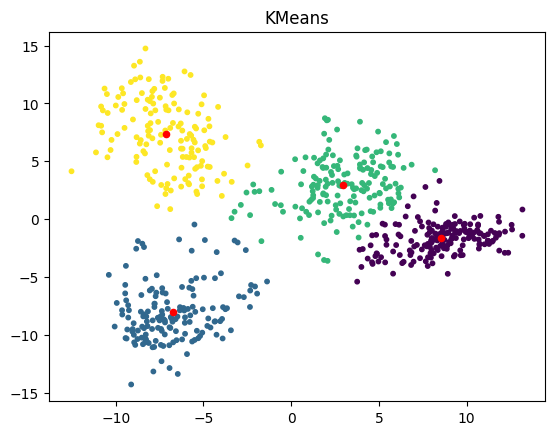

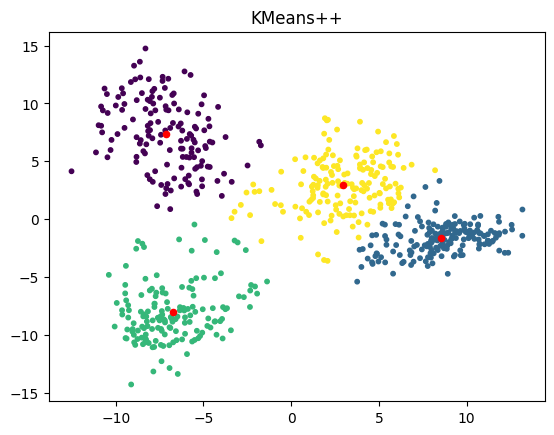

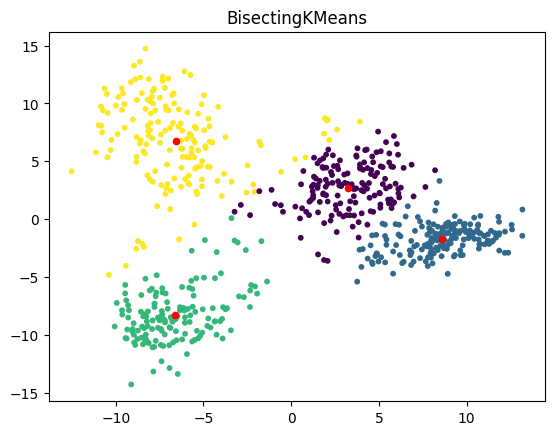

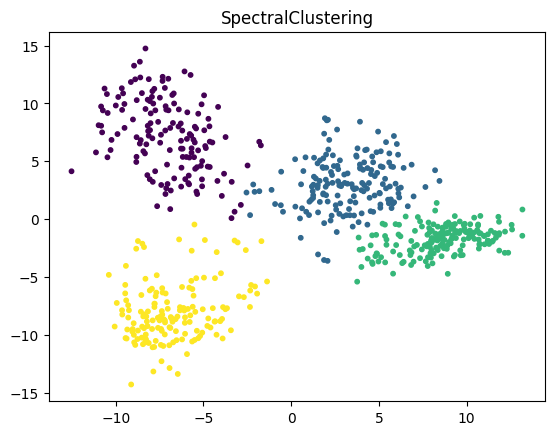

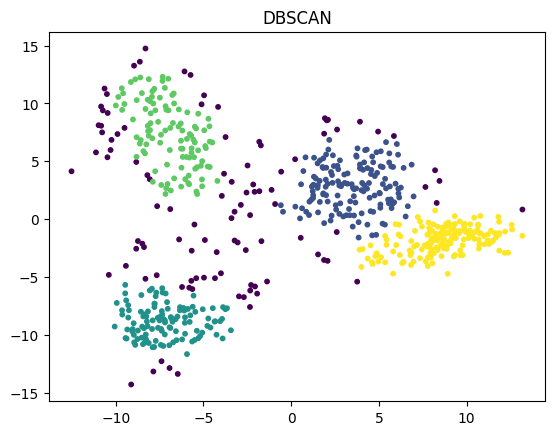

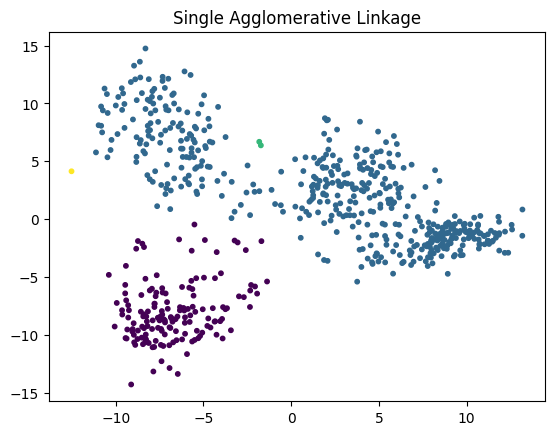

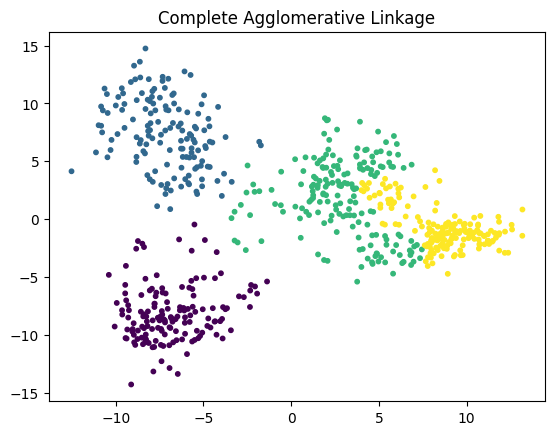

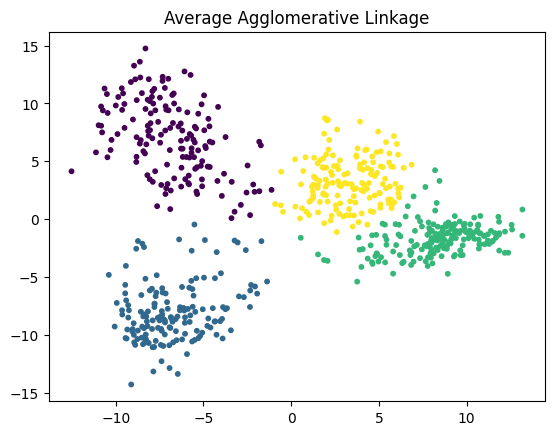

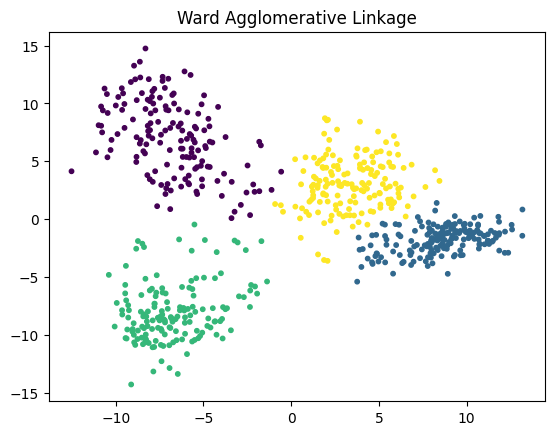

In [32]:
plot_clusters()

# Clustering Evalutions

In [86]:
def ranking(result, method):
    clusters = [kmeans, kmeans_plus, b_kmeans, s_clustering, dbscan_clustering, 
                single_clu, complete_clu, average_clu, ward_clu]
    
    rank = {}
    for i in range(len(result)):
        rank[result[i]] = clusters[i]
    
    ke = list(rank.keys())
    ke.sort(reverse=True)
    
    sorted_dict = {rank[i]: i for i in ke}
    
    print(f"Best to worst for {method}:")
    print("\n".join(f"{key}: {value:0.4f}" for key, value in sorted_dict.items()))

In [87]:
def fowlkes_mallows_score_evaluation():
    results = []    
    clusters = [kmeans, kmeans_plus, b_kmeans, s_clustering, dbscan_clustering, 
                single_clu, complete_clu, average_clu, ward_clu]
    
    for method in clusters:
        results.append(fowlkes_mallows_score(class_labels, method.labels_))
    
    return results, "Fowlkes Mallows Score"

In [88]:
fowlkes_result, method_1 = fowlkes_mallows_score_evaluation()
ranking(fowlkes_result, method_1)

Best to worst for Fowlkes Mallows Score:
SpectralClustering(n_clusters=4): 0.9460
AgglomerativeClustering(n_clusters=4): 0.9403
AgglomerativeClustering(linkage='average', n_clusters=4): 0.9315
KMeans(n_clusters=4, n_init='auto', random_state=0): 0.9288
BisectingKMeans(n_clusters=4, random_state=0): 0.9047
DBSCAN(eps=1.3, min_samples=13): 0.8071
AgglomerativeClustering(linkage='complete', n_clusters=4): 0.7621
AgglomerativeClustering(linkage='single', n_clusters=4): 0.6181


In [89]:
def silhouette_score_evaluation():
    results = []
    clusters = [kmeans, kmeans_plus, b_kmeans, s_clustering, dbscan_clustering, 
                single_clu, complete_clu, average_clu, ward_clu]
    
    for method in clusters:
        results.append(silhouette_score(X, method.labels_))
        
    return results, "Silhouette Score"

In [90]:
silhouette_result, method_2 = silhouette_score_evaluation()
ranking(silhouette_result, method_2)

Best to worst for Silhouette Score:
KMeans(n_clusters=4, n_init='auto', random_state=0): 0.5874
SpectralClustering(n_clusters=4): 0.5871
AgglomerativeClustering(n_clusters=4): 0.5819
AgglomerativeClustering(linkage='average', n_clusters=4): 0.5800
BisectingKMeans(n_clusters=4, random_state=0): 0.5571
AgglomerativeClustering(linkage='complete', n_clusters=4): 0.5016
DBSCAN(eps=1.3, min_samples=13): 0.4541
AgglomerativeClustering(linkage='single', n_clusters=4): 0.0933


# Sources used:

https://kozodoi.me/blog/20210527/extracting-features

https://github.com/ultralytics/ultralytics/issues/4471

https://scikit-learn.org/stable/modules/clustering.html